In [1]:
import os
import datetime
import import_ipynb

import numpy as np
from numpy import nan

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

seed_value= 3
os.environ['PYTHONHASHSEED']=str(seed_value)


In [2]:
#read data 
data = pd.read_csv('6.csv', parse_dates=True)

In [3]:
data.head()

,timestamp,dttm_utc,value,estimated,anomaly
0,1325376600,2012-01-01 00:10:00,52.1147,0,NaN
1,1325376900,2012-01-01 00:15:00,50.9517,0,NaN
2,1325377200,2012-01-01 00:20:00,49.8164,0,NaN
3,1325377500,2012-01-01 00:25:00,49.1795,0,NaN
4,1325377800,2012-01-01 00:30:00,47.6288,0,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105385 entries, 0 to 105384
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  105385 non-null  int64  
 1   dttm_utc   105385 non-null  object 
 2   value      105385 non-null  float64
 3   estimated  105385 non-null  int64  
 4   anomaly    0 non-null       float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.0+ MB


In [5]:
data.drop(columns=["timestamp", 'estimated', 'anomaly'], inplace=True, axis = 1)

In [6]:
data.head()

,dttm_utc,value
0,2012-01-01 00:10:00,52.1147
1,2012-01-01 00:15:00,50.9517
2,2012-01-01 00:20:00,49.8164
3,2012-01-01 00:25:00,49.1795
4,2012-01-01 00:30:00,47.6288


In [7]:
data.set_index(['dttm_utc'], inplace = True)

In [8]:
data.tail()

,value
dttm_utc,
2012-12-31 23:40:00,49.1241
2012-12-31 23:45:00,48.0718
2012-12-31 23:50:00,56.2130
2012-12-31 23:55:00,56.4623
2013-01-01 00:00:00,56.6561


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105385 entries, 2012-01-01 00:10:00 to 2013-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   105385 non-null  float64
dtypes: float64(1)
memory usage: 1.6+ MB


In [10]:
np.isnan(data).sum()

value    0
dtype: int64

In [11]:
data.to_csv('6_cleaned_data.csv')

In [12]:
data = pd.read_csv('6_cleaned_data.csv', parse_dates = True, index_col = 'dttm_utc', low_memory = False)

In [13]:
data.tail()

,value
dttm_utc,
2012-12-31 23:40:00,49.1241
2012-12-31 23:45:00,48.0718
2012-12-31 23:50:00,56.2130
2012-12-31 23:55:00,56.4623
2013-01-01 00:00:00,56.6561


In [14]:
#instead of every 15-minutes, transform data to points per day
data_d = data.resample('D').sum()

In [15]:
data_h = data.resample('H').sum()

In [16]:
data_h.head()

,value
dttm_utc,
2012-01-01 00:00:00,501.9021
2012-01-01 01:00:00,533.4977
2012-01-01 02:00:00,446.2430
2012-01-01 03:00:00,442.9199
2012-01-01 04:00:00,448.2365


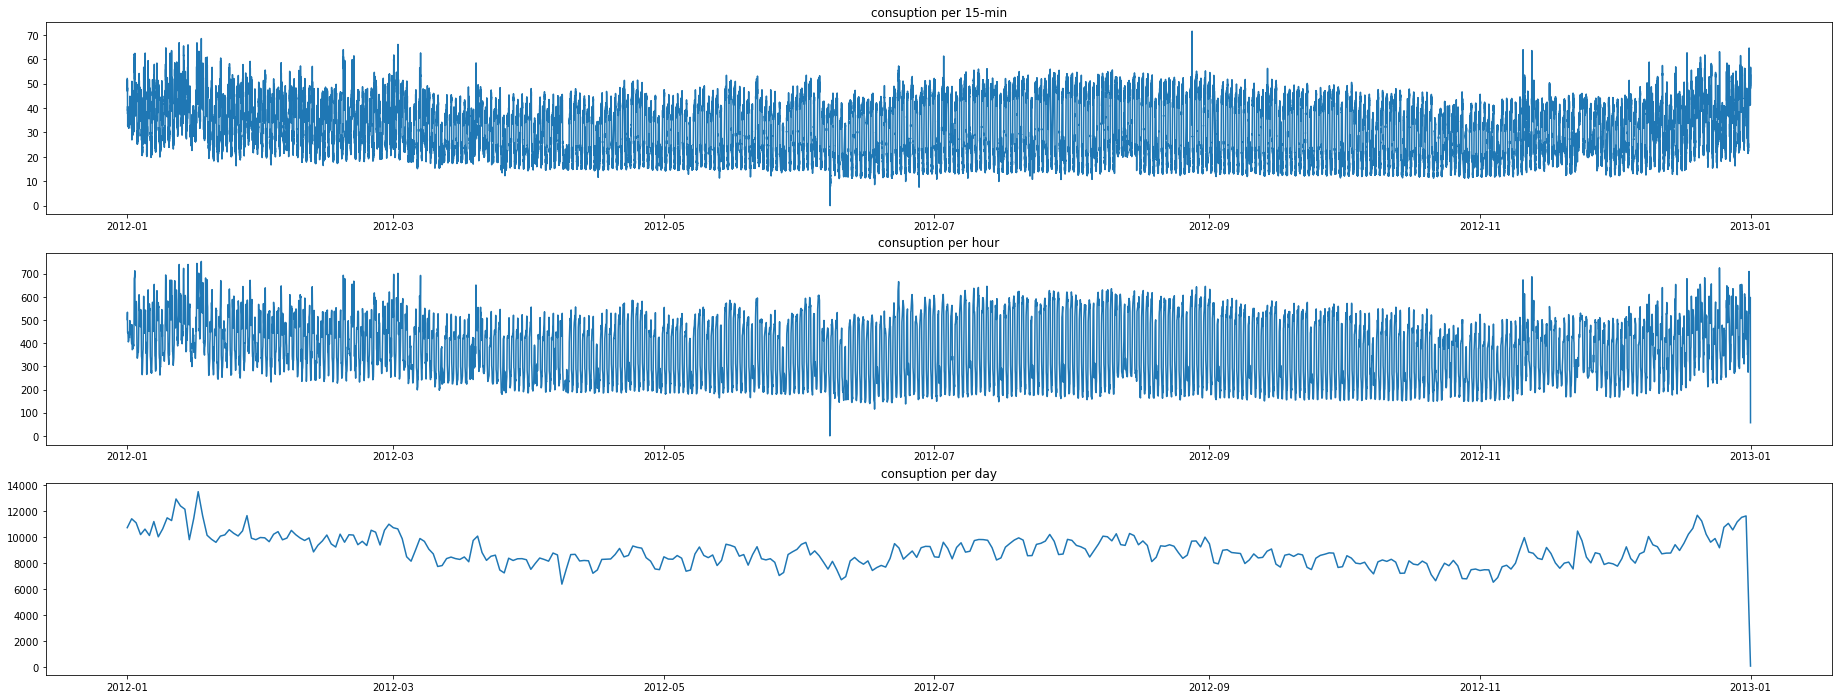

In [17]:
fig, ax = plt.subplots(figsize=(32,12))

plt.subplot(3, 1, 1)
plt.plot(data['value'])
plt.title('consuption per 15-min')

plt.subplot(3, 1, 2)
plt.plot(data_h['value'])
plt.title('consuption per hour')

plt.subplot(3, 1, 3)
plt.plot(data_d['value'])
plt.title('consuption per day')


plt.show()
fig.tight_layout()

In [18]:
data_d.head()

,value
dttm_utc,
2012-01-01,10739.4855
2012-01-02,11427.0567
2012-01-03,11117.6373
2012-01-04,10204.3821
2012-01-05,10628.7493


In [19]:
training = data_h.loc[:'2012-10-01', :]

In [20]:
training.head()

,value
dttm_utc,
2012-01-01 00:00:00,501.9021
2012-01-01 01:00:00,533.4977
2012-01-01 02:00:00,446.2430
2012-01-01 03:00:00,442.9199
2012-01-01 04:00:00,448.2365


In [21]:
testing = data_h.loc['2012-08-01':, :]

In [22]:
testing.head()

,value
dttm_utc,
2012-08-01 00:00:00,598.7379
2012-08-01 01:00:00,601.2857
2012-08-01 02:00:00,588.9352
2012-08-01 03:00:00,445.8275
2012-08-01 04:00:00,318.0327


In [23]:
# tra = training.values.reshape(-1, 1)

In [24]:
# test = testing.values.reshape(-1, 1)

In [25]:
train_scale = MinMaxScaler()
tra = train_scale.fit_transform(training)

In [26]:
test = train_scale.transform(testing)

In [27]:
#creating training data with window size n
x_train, y_train = [], []
wind = 12

for i in range(wind, len(tra)-wind):
    x_train.append(tra[i-wind:i])
    y_train.append(tra[i])

In [28]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [29]:
type(x_train)

numpy.ndarray

In [30]:
x_train.shape, y_train.shape

((6576, 12, 1), (6576, 1))

In [31]:
#creating testing data

In [32]:
x_test, y_test = [], []

for i in range(wind, len(test)-wind):
    x_test.append(test[i-wind:i])
    y_test.append(test[i])

In [33]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [34]:
x_test.shape, y_test.shape

((3649, 12, 1), (3649, 1))

In [35]:
#Creat model

model = Sequential()

model.add(LSTM(200, activation='relu', return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu'))

model.add(Dense(units = 1))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 200)           161600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [38]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32)

Train on 6576 samples
Epoch 1/50
6576/6576 [==============================] - 5s 780us/sample - loss: 0.0304 - mean_absolute_error: 0.1312
Epoch 2/50
6576/6576 [==============================] - 3s 481us/sample - loss: 0.0086 - mean_absolute_error: 0.0695
Epoch 3/50
6576/6576 [==============================] - 3s 484us/sample - loss: 0.0050 - mean_absolute_error: 0.0528s - loss: 0.00 - ETA: 1s - loss: 0.0053 - mean_abso
Epoch 4/50
6576/6576 [==============================] - 3s 481us/sample - loss: 0.0039 - mean_absolute_error: 0.0464
Epoch 5/50
6576/6576 [==============================] - 3s 485us/sample - loss: 0.0036 - mean_absolute_error: 0.0444
Epoch 6/50
6576/6576 [==============================] - 3s 487us/sample - loss: 0.0032 - mean_absolute_error: 0.0407s - loss: 0.0032 
Epoch 7/50
6576/6576 [==============================] - 3s 498us/sample - loss: 0.0032 - mean_absolute_error: 0.0404
Epoch 8/50
6576/6576 [==============================] - 3s 491us/sample - loss: 0.0030 - me

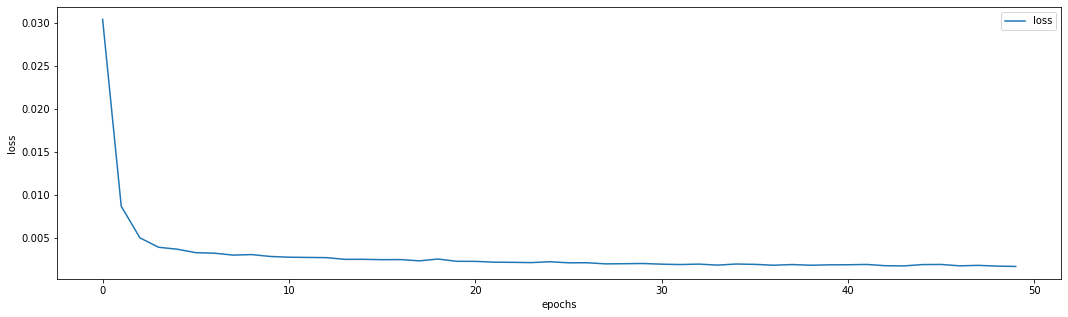

In [39]:
plt.figure(figsize=(18,5))

plt.plot(history.history['loss'],label='loss')
plt.title('')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [40]:
y_pred = model.predict(x_test)

In [41]:
scale= train_scale.scale_[0]
print(scale)

0.0013285004259172366


In [42]:
inv_scale = 1/scale

In [43]:
y_pred = y_pred*inv_scale

In [44]:
y_test = y_test*inv_scale

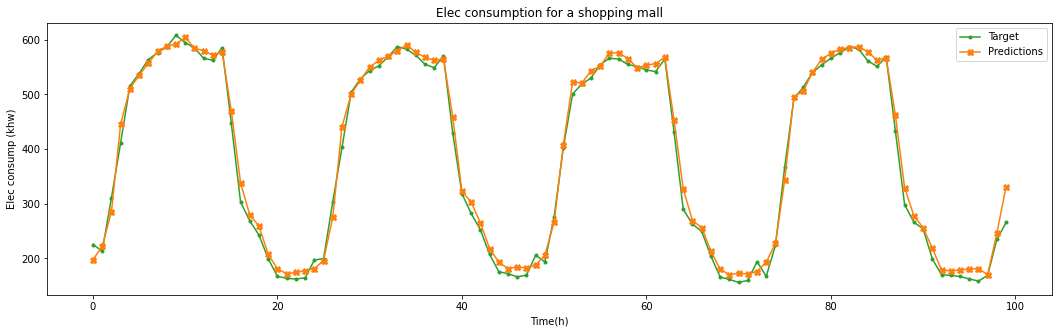

In [48]:
plt.figure(figsize=(18,5))

plt.plot(y_test[:100], marker='.',label='Target', c='#2ca02c')
plt.plot(y_pred[:100], marker='X', label='Predictions',
                  c='#ff7f0e')
plt.title('Elec consumption for a shopping mall')
plt.xlabel('Time(h)')
plt.ylabel('Elec consump (khw)')
plt.legend()
plt.show()

In [46]:
#evaluate model by calculating rmse

def evaluate_model(y_test, y_pred):
    
    #calculate score for whole prediction
    total_score = 0
    for row in range(y_test.shape[0]):
        for col in range(y_pred.shape[1]):
            total_score = total_score + (y_test[row, col] - y_pred[row, col])**2
    total_score = np.sqrt(total_score/(y_test.shape[0]*y_pred.shape[1]))
    
    return total_score

In [47]:
evaluate_model(y_test, y_pred)

35.90836319237617